<a href="https://colab.research.google.com/github/yosriawedi/ML-Project-Insurance/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objectif : Prédire les coûts d'assurance santé pour optimiser la tarification et automatiser les processus.



In [ ]:
# Configuration initiale
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Chargement des données
df = pd.read_csv('dataAssurance.csv')

Data Understanding


Dimensions : (1443, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1406 non-null   float64
 1   sex       1405 non-null   object 
 2   bmi       1410 non-null   float64
 3   children  1414 non-null   float64
 4   smoker    1417 non-null   object 
 5   region    1410 non-null   object 
 6   charges   1414 non-null   float64
dtypes: float64(4), object(3)
memory usage: 79.0+ KB
informations sur les donnes : None
Valeurs manquantes : age         37
sex         38
bmi         33
children    29
smoker      26
region      33
charges     29
dtype: int64
Statistiques descriptives :                age          bmi     children       charges
count  1406.000000  1410.000000  1414.000000   1414.000000
mean     39.179232    30.637681     1.086280  13179.307173
std      14.067120     6.112450     1.196088  11987.371506
min      18.000000    15.9600

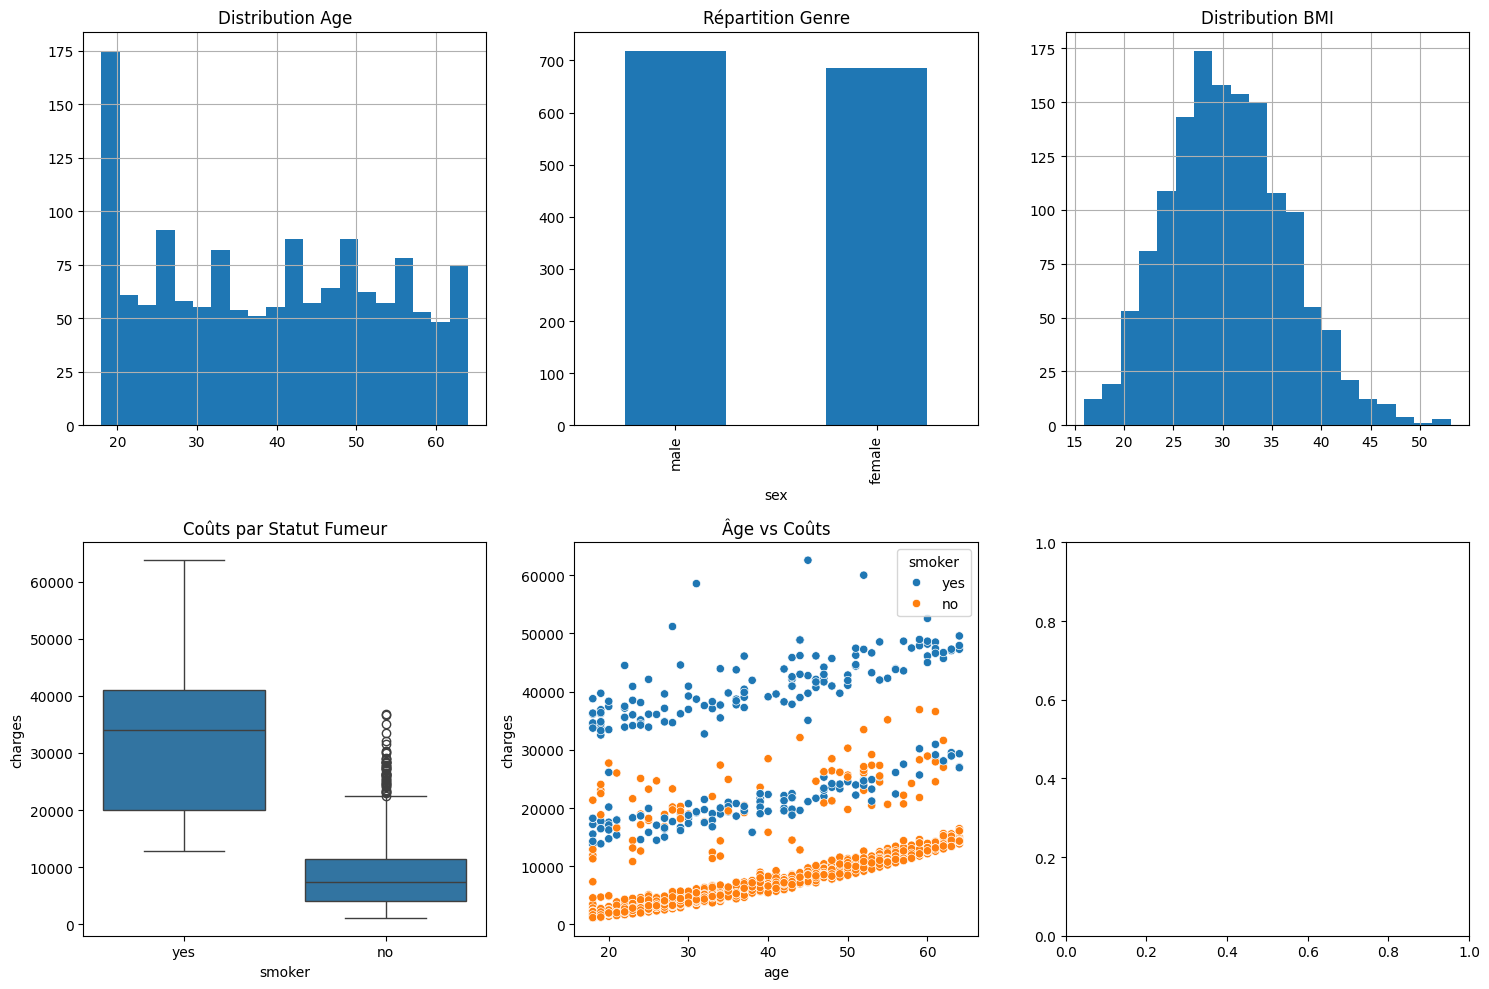

In [ ]:
# Exploration initiale
print(f"Dimensions : {df.shape}")
print(f"informations sur les donnes : {df.info()}")
print(f"Valeurs manquantes : {df.isnull().sum()}")
print(f"Statistiques descriptives : {df.describe()}")
#visualisations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
df['age'].hist(ax=axes[0,0], bins=20)
axes[0,0].set_title('Distribution Age')

df['sex'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Répartition Genre')

df['bmi'].hist(ax=axes[0,2], bins=20)
axes[0,2].set_title('Distribution BMI')

sns.boxplot(data=df, x='smoker', y='charges', ax=axes[1,0])
axes[1,0].set_title('Coûts par Statut Fumeur')

sns.scatterplot(data=df, x='age', y='charges', hue='smoker', ax=axes[1,1])
axes[1,1].set_title('Âge vs Coûts')

plt.tight_layout()
plt.show()


Data preparation

In [ ]:
# 3. Data Preparation
print("Noms des colonnes dans le DataFrame:", df.columns.tolist())

# Vérification et nettoyage des noms de colonnes
df.columns = df.columns.str.strip()  # Supprimer les espaces autour des noms de colonnes

# Gestion des valeurs manquantes
print("\nValeurs manquantes avant traitement:")
print(df.isnull().sum())

# Remplissage des valeurs manquantes
df['bmi'].fillna(df['bmi'].median(), inplace=True)
df['children'].fillna(df['children'].median(), inplace=True)

# Suppression des lignes avec des valeurs manquantes critiques
df = df.dropna(subset=['charges', 'age'])

# Vérification des types de données
print("\nTypes de données:")
print(df.dtypes)

# Conversion des variables catégorielles
categorical_cols = ['sex', 'smoker', 'region']
for col in categorical_cols:
    if col in df.columns:
        print(f"Valeurs uniques dans {col}: {df[col].unique()}")

# Vérification que les colonnes catégorielles existent
existing_categorical = [col for col in categorical_cols if col in df.columns]
if existing_categorical:
    df = pd.get_dummies(df, columns=existing_categorical, drop_first=True)
else:
    print("Aucune colonne catégorielle trouvée")

print(f"\nDimensions après prétraitement: {df.shape}")
print("Nouvelles colonnes:", df.columns.tolist())

Noms des colonnes dans le DataFrame: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

Valeurs manquantes avant traitement:
age         37
sex         38
bmi         33
children    29
smoker      26
region      33
charges     29
dtype: int64

Types de données:
age         float64
sex          object
bmi         float64
children    float64
smoker       object
region       object
charges     float64
dtype: object
Valeurs uniques dans sex: ['female' 'male' nan]
Valeurs uniques dans smoker: ['yes' 'no' nan]
Valeurs uniques dans region: ['southwest' 'southeast' 'northwest' 'northeast' nan]

Dimensions après prétraitement: (1378, 9)
Nouvelles colonnes: ['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']


/tmp/ipython-input-2290163298.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)
/tmp/ipython-input-2290163298.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Modeling


In [ ]:
print("=== PHASE DE MODÉLISATION ===")

# Séparation des features et de la target
X = df.drop('charges', axis=1)
y = df['charges']

print(f"Nombre de features: {X.shape[1]}")
print(f"Nombre d'échantillons: {X.shape[0]}")

# Identification des types de colonnes
numeric_features = ['age', 'bmi', 'children']
categorical_features = [col for col in X.columns if col not in numeric_features]

print(f"\nColonnes numériques: {numeric_features}")
print(f"Colonnes catégorielles: {categorical_features}")

# Définition du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)  # On garde les variables catégorielles déjà encodées
    ]
)

# Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nDonnées d'entraînement: {X_train.shape[0]} échantillons")
print(f"Données de test: {X_test.shape[0]} échantillons")

# Pipeline de modélisation
print("\nCréation du pipeline de modélisation...")
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        max_depth=10
    ))
])

# Entraînement du modèle
print("Début de l'entraînement du modèle...")
model.fit(X_train, y_train)
print("Entraînement terminé avec succès!")

# Prédictions
print("\nGénération des prédictions...")
y_pred = model.predict(X_test)

# Affichage des premières prédictions vs valeurs réelles
print("\nComparaison des premières prédictions vs valeurs réelles:")
comparison_df = pd.DataFrame({
    'Valeur Réelle': y_test.values[:10],
    'Prédiction': y_pred[:10],
    'Erreur Absolue': np.abs(y_test.values[:10] - y_pred[:10])
})
print(comparison_df.round(2))

=== PHASE DE MODÉLISATION ===
Nombre de features: 8
Nombre d'échantillons: 1378

Colonnes numériques: ['age', 'bmi', 'children']
Colonnes catégorielles: ['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']

Données d'entraînement: 1102 échantillons
Données de test: 276 échantillons

Création du pipeline de modélisation...
Début de l'entraînement du modèle...
Entraînement terminé avec succès!

Génération des prédictions...

Comparaison des premières prédictions vs valeurs réelles:
   Valeur Réelle  Prédiction  Erreur Absolue
0       11326.71     5422.28         5904.44
1        8604.48     9028.39          423.91
2        8283.68     9649.47         1365.79
3        4934.70     5963.09         1028.39
4        3366.67     4610.71         1244.04
5        8582.30     9754.83         1172.53
6       17663.14    19468.85         1805.70
7        6414.18     6703.24          289.06
8        6837.37     7967.35         1129.98
9       11741.73    13249.64   

Evaluation


MAE: 2567.02 $
R² Score: 0.8555
✅ Objectif MAE < 3000 $ atteint!


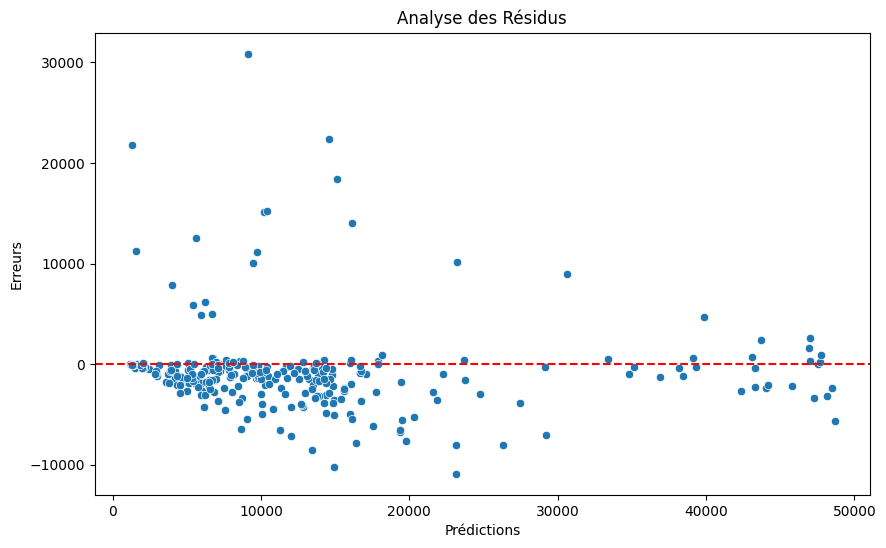

In [ ]:
# Métriques
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} $")
print(f"R² Score: {r2:.4f}")

# Vérification objectif métier
if mae < 3000:
    print("✅ Objectif MAE < 3000 $ atteint!")
else:
    print("❌ Objectif MAE non atteint")

# Analyse des résidus
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Analyse des Résidus')
plt.xlabel('Prédictions')
plt.ylabel('Erreurs')
plt.show()

Deployment

In [ ]:
# Export du modèle
import joblib
joblib.dump(model, 'modele_assurance.pkl')

# Exemple de prédiction unique
exemple_data = pd.DataFrame([{
    'age': 35,
    'bmi': 28.5,
    'children': 2,
    'sex_male': 1,
    'smoker_yes': 0,
    'region_northwest': 1,
    'region_southeast': 0,
    'region_southwest': 0
}])

prediction = model.predict(exemple_data)
print(f"Coût prédit: {prediction[0]:.2f} $")

Coût prédit: 6608.44 $


In [9]:
!git config --global user.email "saadaoui.baha@esprit.tn"


In [10]:
!git config --global user.name "baha"


In [11]:
!git clone https://github.com/yosriawedi/ML-Project-Insurance.git
%cd ML-Project-Insurance


Cloning into 'ML-Project-Insurance'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 824.38 KiB | 10.05 MiB/s, done.
/content/ML-Project-Insurance


In [12]:
!git checkout -b baha


Switched to a new branch 'baha'


In [23]:
from google.colab import files

# Crée une copie du notebook actuel
!cp "/content/$(ls /content/*.ipynb | head -1)" "/content/ML.ipynb"

# Vérifie que le fichier a été créé
!ls -la /content/ML.ipynb

ls: cannot access '/content/*.ipynb': No such file or directory
cp: -r not specified; omitting directory '/content/'
ls: cannot access '/content/ML.ipynb': No such file or directory
